# Group Project Programming of Bioinformatics
## Group 1  20211
### Authors:
TAN WEN YIT (A18CS0259) <br>
LIM JIA YEE (A18CS) <br>
KAM SHWU CHIN (A18CS) <br>
<hr>

## Title: Application of Deep Learning in Diagnosis of HCC Through CT Scan Images
The application of Deep Learning is essential in solving current problems in the industries such as recommendation algorithm (e.g. YouTube Recommendation Algorithm), speech recognition, object recognition, gestures and etc. In this mini project, we would love to demonstrate the diagnosis of HCC using Convolutional Neural Network (CNN) by using **Keras** (Tensorflow as framework)
<hr>
<b>Make sure you have TensorFlow/TensorFlow for GPU, Keras, Numpy, Pandas, Skimage installed in your environment through Anaconda</b>

### 1. Import essential packages
**Keras** has packages to build up a CNN whereas **Numpy** is imported to manage with images.<br>
**Pandas** is imported to read dataframe of the list of the images we have prepared as well as their labels.<br>
**Skimage** is imported as well to read image in grayscale and normalize the value from 0 - 255 to 0 - 1.<br>

In [1]:
import numpy as np
import pandas as pd
from keras.utils import np_utils
from skimage import io
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Convolution2D, MaxPooling2D

### 2. Import the images and labels using .csv file as guide
The metadata of the images are stored in .csv file.<br>
We need to fetch it by using **Pandas** package.<br>
Then, we will convert the dataframe into **numpy** array because we will use arrays as a references of the images we need to fetch.<br><br>

Images are read as grayscale images and all have equal size (512 x 512).<br>
The images are stored in 3D array (1 x 512 x 512), so when we stack up the array we will have (total_num_of_images x 512 x 512).<br>

In [2]:
# read .csv file
img_info_df = pd.read_csv('HCC_datasets_w_ohe.csv')
img_name_df = pd.DataFrame(img_info_df['Images'], columns=['Images'])
labels_df = pd.DataFrame(img_info_df['HCC_Yes'], columns=['HCC_Yes'])

# flattening array into 1-D
images_name_all = img_name_df.to_numpy().reshape(-1)
labels_all = labels_df.to_numpy().reshape(-1)
images_all = np.empty([1, 512, 512]) # later we need to remove the first element
# print(images_all.shape)

print("Reading images...")
# read images into ndarray with dimensions (total_images, 512, 512, 1)
for image in images_name_all:
    tempName = 'HCC_datasets/' + image
    img_gs = io.imread(tempName, as_gray=True)
    img_gs = img_gs.reshape((1, 512, 512))
    images_all = np.vstack((images_all, img_gs))

print("Images reading completed.")
# print(images_all.shape)
images_all = np.delete(images_all, 0, axis=0) # remove the first element which contains empty array
images_all = images_all.reshape(images_name_all.shape[0], 512, 512, 1) # reshape the array for CNN odel later

Reading images...
Images reading completed.


### 3. Preprocess the datasets and split into training and testing set (parallel arrays)
We need to split the images into **training set** and **tesing set**.<br>
We will use normal distribution to randomize a set of random number.<br>
Then, we will get the percentile (70%) from the set of numbers obtained.<br>
For each number in the set, if the number is less than percentile 70%, then it will become <code>True</code> and vice versa.<br>
Eventually, we have a filter mask with random selection of 70% to become training set.<br>
Filter mask of 30% testing set will be the complement of the filter mask of training set using loop.<br>
Last but not least, we have to categorize the **label**, our label are 0 (HCC absent) and 1 (HCC present).<br>

In [3]:
# create filter that splits datasets to 70/30
rand_num_list = np.random.normal(size=(images_name_all.shape[0]))
boundary = np.percentile(rand_num_list, 70)
train_filter, test_filter = [], []
true_num, false_num = 0, 0

# create filter mask for training set
for num in rand_num_list:
    if num < boundary:
        train_filter.append(True)
        true_num += 1
    else:
        train_filter.append(False)
        false_num += 1

# create filter mask for testing set based on training filter
for boo in train_filter:
    if boo:
        test_filter.append(False)
    else:
        test_filter.append(True)

# filter the datasets into training and testing set
training_img_name = images_name_all[train_filter]
training_sets = images_all[train_filter]
training_labels = labels_all[train_filter]

testing_img_name = images_name_all[test_filter]
testing_sets = images_all[test_filter]
testing_labels = labels_all[test_filter]

# categorize the label into YES(1) and NO(0)
c_training_labels = np_utils.to_categorical(training_labels, 2)
c_testing_labels = np_utils.to_categorical(testing_labels, 2)

### 4. Define hyperparameters
**Hyperparameters** are the parameters that can be manually altered (or similar to **constant**). Here, we can set **feature map number**, or other parameters such as **kernel size**, **input_size**, and etc.

In [4]:
feature_map_num = 64

### 5. Build CNN models
**Sequential()** is a framework to build up the neural network model.<br>
<b>Convolutional2D(), MaxPooling2D, Dense()</b> are the layers in the **Sequential()**.<br>


In [5]:
convnet = Sequential()
convnet.add(Convolution2D(feature_map_num, 4, 4, activation='relu', input_shape=(512, 512, 1)))
convnet.add(Convolution2D(feature_map_num, 3, 3, activation='relu'))
convnet.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
convnet.add(Convolution2D(feature_map_num, 2, 2, activation='relu'))
convnet.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
convnet.add(Convolution2D(feature_map_num, 2, 2, activation='relu'))
convnet.add(Flatten())
convnet.add(Dense(2, activation='softmax'))

### 6. Compile the model
The optimizer used is called **Stochastic Gradient Descent** where the weights update are done after a random set from datasets are forward passed and backpropagated.

In [6]:
convnet.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])

We can also get the summary of the model built such as output size of each layers and the number of parameters involved in each layer.

In [7]:
convnet.summary()
print("Number of weights after calling the model:", len(convnet.weights), "\n")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1088      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 41, 41, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        16448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 64)          16448     
_________________________________________________________________
flatten (Flatten)            (None, 5184)              0

### 7. Train the model with training set
<code>batch_size</code> is the size of batch to train and update the weight of the model. We use 1 random sample per batch because our samples are fews only (140) and the training takes only a while to be done. If the samples is huge, then we have to specify larger batch size to perform weights update since we are using **Stochastic Gradient Descent**. (e.g. <code>batch_size = 64</code> indicating that the whole training set are just randomly picked 64 samples and being trained, forming an iteration. If we have, says 128 samples, then it takes 2 iterations to complete 1 **epoch**).<br><br>
<i>The code below will perform 98 iterations per epoch, achieveing higher accuracy.</i>

In [8]:
model_with_metrics = convnet.fit(training_sets, c_training_labels, batch_size=1, epochs=30, verbose=1)
print()

Epoch 1/30
136/136 [==============================] - 0s 3ms/step - loss: 0.2443 - accuracy: 0.5588
Epoch 2/30
136/136 [==============================] - 0s 3ms/step - loss: 0.2427 - accuracy: 0.5809
Epoch 3/30
136/136 [==============================] - 0s 3ms/step - loss: 0.2361 - accuracy: 0.6176
Epoch 4/30
136/136 [==============================] - 0s 3ms/step - loss: 0.2362 - accuracy: 0.5956
Epoch 5/30
136/136 [==============================] - 0s 3ms/step - loss: 0.2217 - accuracy: 0.6618
Epoch 6/30
136/136 [==============================] - 0s 3ms/step - loss: 0.2213 - accuracy: 0.7279
Epoch 7/30
136/136 [==============================] - 0s 3ms/step - loss: 0.2029 - accuracy: 0.7206
Epoch 8/30
136/136 [==============================] - 0s 3ms/step - loss: 0.1751 - accuracy: 0.7721
Epoch 9/30
136/136 [==============================] - 0s 3ms/step - loss: 0.1443 - accuracy: 0.8235
Epoch 10/30
136/136 [==============================] - 0s 3ms/step - loss: 0.1094 - accuracy: 0.8824

### 8. Evaluate the model using testing set
We use the testing set to evaluate our model and tell us how accurate the model is.

In [9]:
metrics = convnet.evaluate(testing_sets, c_testing_labels, verbose=1)
print("\n%s: %.2f%%\n" % (convnet.metrics_names[1], metrics[1]*100))

2/2 [==============================] - 0s 36ms/step - loss: 0.0302 - accuracy: 0.9661

accuracy: 96.61%



### 9. Using the model to predict using testing set again

In [10]:
predictions = convnet.predict(testing_sets)

### 10. Get the overall result of prediction

In [11]:
i = 0
while i < len(test_filter):
    if predictions[i][0] > predictions[i][1]:
        print(testing_img_name[i] + ": ", predictions[i], "Result: NO")
    else:
        print(testing_img_name[i] + ": ", predictions[i], "Result: YES")
    i += 1


bc-a10x-03291993-1-05.jpg:  [0.01366673 0.9863333 ] Result: YES
bc-a10z-12201993-01-33.jpg:  [0.0048438 0.9951563] Result: YES
bc-a10z-12201993-01-34.jpg:  [0.00497348 0.9950265 ] Result: YES
bc-a10z-12201993-01-36.jpg:  [0.00409363 0.99590635] Result: YES
bc-a69h-05272003-1-19.jpg:  [0.03504045 0.9649596 ] Result: YES
bc-a69h-05272003-1-20.jpg:  [0.05498015 0.9450199 ] Result: YES
dd-a113-24161-1-046.jpg:  [0.20167834 0.7983217 ] Result: YES
dd-a113-86495-1-029.jpg:  [0.23032016 0.76967984] Result: YES
dd-a114-71147-1-40.jpg:  [0.00251763 0.99748236] Result: YES
dd-a114-71147-1-42.jpg:  [0.01841494 0.981585  ] Result: YES
dd-a118-19398-1-14.jpg:  [9.453357e-04 9.990546e-01] Result: YES
dd-a119-76072-1-015.jpg:  [0.09161957 0.90838045] Result: YES
dd-a119-76072-1-016.jpg:  [0.07805856 0.92194146] Result: YES
dd-a119-76072-1-018.jpg:  [0.01009686 0.9899031 ] Result: YES
dd-a11a-55688-1-25.jpg:  [0.01245626 0.9875437 ] Result: YES
dd-a11a-55688-1-27.jpg:  [0.00498346 0.9950165 ] Result: 

IndexError: index 59 is out of bounds for axis 0 with size 59

<hr>

## Analysis

Here will analyze how the model learns by adjusting weights and the loss of the training process as well as the accuracy for each epoch.<br>
We will use the metrics['loss', 'accuracy'] to visualize the training process.<br><br>
Read and store each metric into a variable

In [20]:
import matplotlib.pyplot as plt
epoch = [x for x in range(1, len(model_with_metrics.history['loss']) + 1)]
loss = model_with_metrics.history['loss']
accuracy = model_with_metrics.history['accuracy']


Plot graph for loss

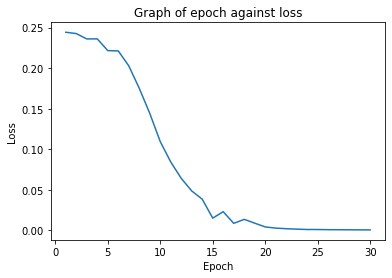

In [22]:
plt.plot(epoch, loss)
plt.title('Graph of epoch against loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Plot graph for accuracy

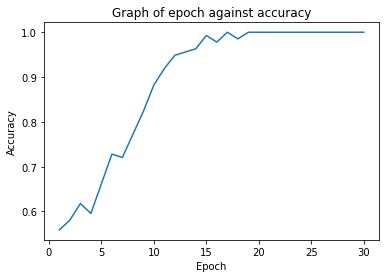

In [23]:
plt.plot(epoch, accuracy)
plt.title('Graph of epoch against accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()